In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

### Preparación de datos

In [2]:
RSEED = 50

In [3]:
df = pd.read_csv('2015_health.csv').sample(100000, random_state = RSEED)
df.head()

,_STATE,FMONTH,IDATE,IMONTH,IDAY,IYEAR,DISPCODE,SEQNO,_PSU,CTELENUM,...,_PAREC1,_PASTAE1,_LMTACT1,_LMTWRK1,_LMTSCL1,_RFSEAT2,_RFSEAT3,_FLSHOT6,_PNEUMO2,_AIDTST3
383119,49.0,4.0,b'05192015',b'05',b'19',b'2015',1100.0,2.015009e+09,2.015009e+09,NaN,...,4.0,2.0,3.0,3.0,4.0,1.0,1.0,NaN,NaN,2.0
55536,9.0,9.0,b'09232015',b'09',b'23',b'2015',1100.0,2.015005e+09,2.015005e+09,1.0,...,2.0,2.0,3.0,3.0,4.0,1.0,1.0,NaN,NaN,2.0
267093,34.0,10.0,b'11052015',b'11',b'05',b'2015',1100.0,2.015011e+09,2.015011e+09,NaN,...,4.0,2.0,3.0,3.0,4.0,1.0,1.0,NaN,NaN,2.0
319092,41.0,4.0,b'04062015',b'04',b'06',b'2015',1100.0,2.015002e+09,2.015002e+09,1.0,...,2.0,2.0,2.0,2.0,3.0,1.0,1.0,2.0,1.0,2.0
420978,54.0,5.0,b'05112015',b'05',b'11',b'2015',1100.0,2.015004e+09,2.015004e+09,NaN,...,1.0,1.0,3.0,3.0,4.0,1.0,1.0,NaN,NaN,2.0


In [4]:
#a = np.array(list(df.isna().sum())) == 0

In [5]:
#df = pd.DataFrame(df.values[:,a])

In [6]:
#df.shape

In [7]:
df = df.select_dtypes('number')

In [8]:
#df.shape

In [9]:
df['_RFHLTH'] = df['_RFHLTH'].replace({2: 0})
df = df.loc[df['_RFHLTH'].isin([0, 1])].copy()
df = df.rename(columns = {'_RFHLTH': 'label'})
df['label'].value_counts()

1.0    81140
0.0    18579
Name: label, dtype: int64

In [10]:
#se eliminan por valores vacios
df = df.drop(columns = ['POORHLTH', 'PHYSHLTH', 'GENHLTH', 'PAINACT2', 
                        'QLMENTL2', 'QLSTRES2', 'QLHLTH2', 'HLTHPLN1', 'MENTHLTH', '_FLSHOT6', '_PNEUMO2', '_AIDTST3'])

In [11]:
df.shape

(99719, 311)

In [12]:
# Correlaciones 
df_corr = df.corr()['label'].sort_values()

print(df_corr.head(15), '\n')
print(df_corr.tail(15))

ARTTODAY   -0.422346
VIDFCLT2   -0.342752
LSATISFY   -0.266706
EMPLOY1    -0.264455
VIREDIF3   -0.255475
ALCDAY5    -0.179098
ASDRVIST   -0.175568
INTERNET   -0.175431
_RFHYPE5   -0.174186
ASRCHKUP   -0.169301
EMTSUPRT   -0.161275
_BMI5      -0.147529
STRENGTH   -0.138802
_AGE80     -0.137554
EXERANY2   -0.133207
Name: label, dtype: float64 

QLACTLM2    0.242042
_DRDXAR1    0.248934
SCNTMEL1    0.257163
DIFFWALK    0.274334
CDHOUSE     0.289901
CDSOCIAL    0.305841
ARTHSOCL    0.325730
CDASSIST    0.328240
label       1.000000
CTELENUM         NaN
COLGHOUS         NaN
STATERES         NaN
CTELNUM1         NaN
CELLFON2         NaN
CCLGHOUS         NaN
Name: label, dtype: float64


In [13]:
labels = np.array(df.pop('label'))

train, test, train_labels, test_labels = train_test_split(df, labels, 
                                                          stratify = labels,
                                                          test_size = 0.3, 
                                                          random_state = RSEED)

In [24]:
train = train.fillna(train.mean())
test = test.fillna(test.mean())

features = list(train.columns)

In [25]:
print(train.shape)
print(test.shape)

(69803, 310)
(29916, 310)


In [26]:
tree = DecisionTreeClassifier(random_state=RSEED)

In [27]:
#Esto para determinar la profundidad sencilla del arbol. Cuando la profundidad es muy alta, se pueden presentar
#problemas de sobreajuste
tree.fit(train, train_labels)
print(f'El arbol de decisión tiene {tree.tree_.node_count} nodos con profundidad máxima de {tree.tree_.max_depth}.')

El arbol de decisión tiene 12379 nodos con profundidad máxima de 55.


In [28]:
train_probs = tree.predict_proba(train)[:, 1]
probs = tree.predict_proba(test)[:, 1]

train_predictions = tree.predict(train)
predictions = tree.predict(test)

In [29]:
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve, accuracy_score

print(f'ROC AUC de Entrenamiento: {roc_auc_score(train_labels, train_probs)}')
print(f'ROC AUC  de Testeo: {roc_auc_score(test_labels, probs)}')

ROC AUC de Entrenamiento: 1.0
ROC AUC  de Testeo: 0.6712571325069145


In [30]:
from collections import Counter
print(Counter(probs))
print(Counter(predictions))

Counter({1.0: 23537, 0.0: 6379})
Counter({1.0: 23537, 0.0: 6379})


Recall Baseline: 1.0 Test: 0.85 Train: 1.0
Precision Baseline: 0.81 Test: 0.88 Train: 1.0
Roc Baseline: 0.5 Test: 0.67 Train: 1.0
Accuracy Baseline: 0.81 Test: 0.78 Train: 1.0


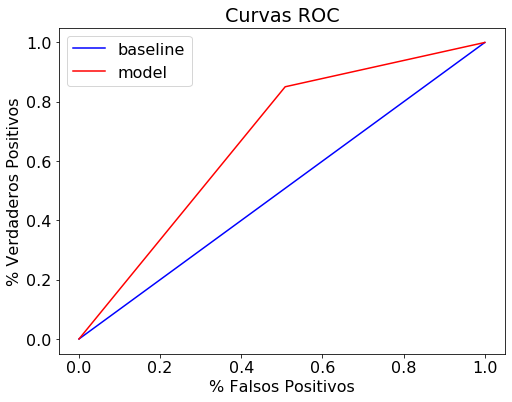

In [31]:
evaluate_model(predictions, probs, train_predictions, train_probs)

Matriz de confunsión sin normalizar


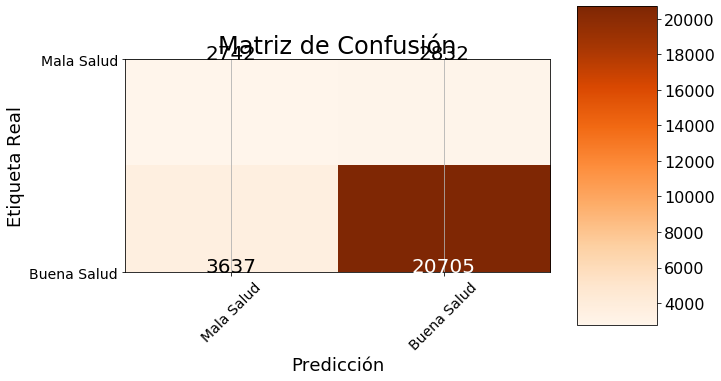

In [32]:
cm = confusion_matrix(test_labels, predictions)
plot_confusion_matrix(cm, classes = ['Mala Salud', 'Buena Salud'],
                      title = 'Matriz de Confusión')

In [33]:
fi = pd.DataFrame({'feature': features,
                   'importance': tree.feature_importances_}).\
                    sort_values('importance', ascending = False)
fi.head(20)

,feature,importance
62,DIFFWALK,0.191773
58,QLACTLM2,0.030716
51,EMPLOY1,0.023860
64,DIFFALON,0.018356
245,_BMI5,0.016940
54,INTERNET,0.015827
226,_MICHD,0.014048
41,DIABETE3,0.012972
221,_LLCPWT,0.012247
211,_STSTR,0.011953


### Random Forest

In [34]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(random_state=RSEED, 
                               max_features = 'sqrt',
                               n_jobs=-1, verbose = 1)


model.fit(train, train_labels)

C:\Users\victo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.5s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.8s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                       oob_score=False, random_state=50, verbose=1,
                       warm_start=False)

In [35]:
n_nodes = []
max_depths = []

for ind_tree in model.estimators_:
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print(f'Número promedio de nodos {int(np.mean(n_nodes))}')
print(f'Máximo de profundidad {int(np.mean(max_depths))}')

Número promedio de nodos 13304
Máximo de profundidad 46


In [36]:
train_rf_predictions = model.predict(train)
train_rf_probs = model.predict_proba(train)[:, 1]

rf_predictions = model.predict(test)
rf_probs = model.predict_proba(test)[:, 1]

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished


Recall Baseline: 1.0 Test: 0.92 Train: 1.0
Precision Baseline: 0.81 Test: 0.89 Train: 1.0
Roc Baseline: 0.5 Test: 0.83 Train: 1.0
Accuracy Baseline: 0.81 Test: 0.84 Train: 0.99


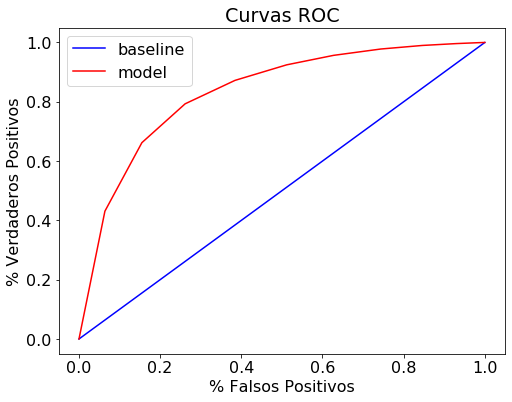

In [37]:
evaluate_model(rf_predictions, rf_probs, train_rf_predictions, train_rf_probs)

Matriz de confunsión sin normalizar


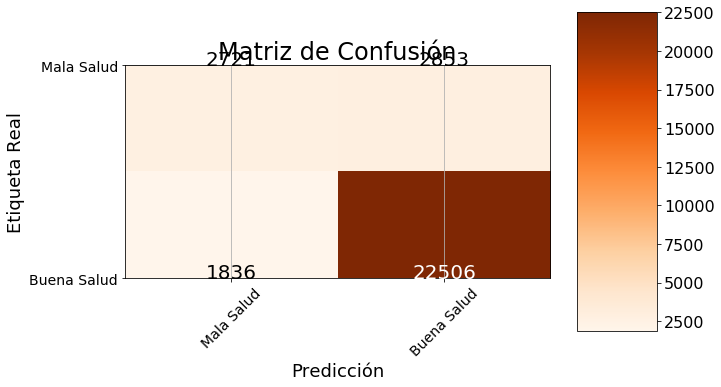

In [38]:
cm = confusion_matrix(test_labels, rf_predictions)
plot_confusion_matrix(cm, classes = ['Mala Salud', 'Buena Salud'],
                      title = 'Matriz de Confusión')

In [39]:
fi_model = pd.DataFrame({'feature': features,
                   'importance': model.feature_importances_}).\
                    sort_values('importance', ascending = False)
fi_model.head(20)

,feature,importance
62,DIFFWALK,0.057163
59,USEEQUIP,0.037574
58,QLACTLM2,0.034455
88,LMTJOIN3,0.019307
307,_LMTSCL1,0.017646
51,EMPLOY1,0.016385
61,DECIDE,0.014233
64,DIFFALON,0.013191
245,_BMI5,0.011504
305,_LMTACT1,0.010975


### Optimización de Random Forest buscando parámetros de forma aleatoria

In [40]:
from sklearn.model_selection import RandomizedSearchCV


param_grid = {
    'n_estimators': np.linspace(10, 200).astype(int),
    'max_depth': [None] + list(np.linspace(3, 20).astype(int)),
    'max_features': ['auto', 'sqrt', None] + list(np.arange(0.5, 1, 0.1)),
    'max_leaf_nodes': [None] + list(np.linspace(10, 50, 500).astype(int)),
    'min_samples_split': [2, 5, 10],
    'bootstrap': [True, False]
}


estimator = RandomForestClassifier(random_state = RSEED)


rs = RandomizedSearchCV(estimator, param_grid, n_jobs = -1, 
                        scoring = 'roc_auc', cv = 3, 
                        n_iter = 10, verbose = 1, random_state=RSEED)


rs.fit(train, train_labels)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 15.7min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators='warn',
                                                    n_jobs=None

In [41]:
rs.best_params_

{'n_estimators': 29,
 'min_samples_split': 5,
 'max_leaf_nodes': 43,
 'max_features': 'auto',
 'max_depth': 16,
 'bootstrap': True}

In [42]:
best_model = rs.best_estimator_

In [43]:
train_rf_predictions = best_model.predict(train)
train_rf_probs = best_model.predict_proba(train)[:, 1]

rf_predictions = best_model.predict(test)
rf_probs = best_model.predict_proba(test)[:, 1]

Recall Baseline: 1.0 Test: 0.97 Train: 0.98
Precision Baseline: 0.81 Test: 0.86 Train: 0.87
Roc Baseline: 0.5 Test: 0.87 Train: 0.88
Accuracy Baseline: 0.81 Test: 0.85 Train: 0.86


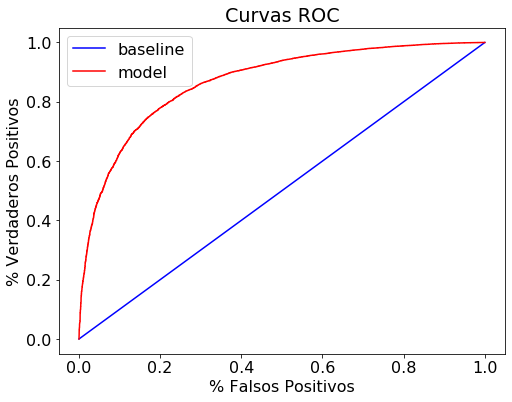

In [44]:
evaluate_model(rf_predictions, rf_probs, train_rf_predictions, train_rf_probs)

Matriz de confunsión sin normalizar


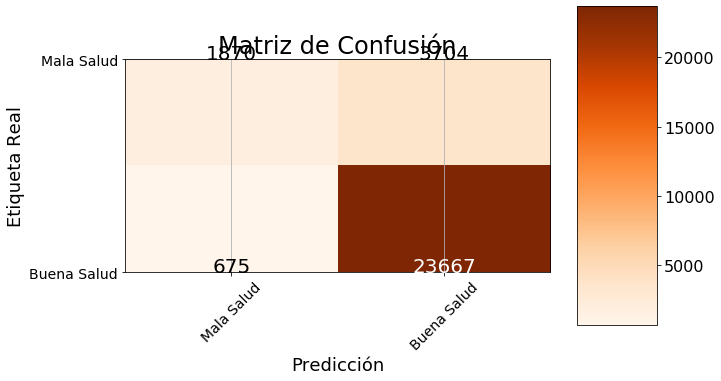

In [46]:
cm = confusion_matrix(test_labels, rf_predictions)
plot_confusion_matrix(cm, classes = ['Mala Salud', 'Buena Salud'],
                      title = 'Matriz de Confusión')

In [48]:
print(Counter(rf_predictions))

Counter({1.0: 27371, 0.0: 2545})


In [49]:
cm

array([[ 1870,  3704],
       [  675, 23667]], dtype=int64)

In [19]:
def evaluate_model(predictions, probs, train_predictions, train_probs):
  
    
    baseline = {}
    
    baseline['recall'] = recall_score(test_labels, [1 for _ in range(len(test_labels))])
    baseline['precision'] = precision_score(test_labels, [1 for _ in range(len(test_labels))])
    baseline['roc'] = 0.5
    baseline['accuracy'] = accuracy_score(test_labels, [1 for _ in range(len(test_labels))])
    
    results = {}
    
    results['recall'] = recall_score(test_labels, predictions)
    results['precision'] = precision_score(test_labels, predictions)
    results['roc'] = roc_auc_score(test_labels, probs)
    results['accuracy'] = accuracy_score(test_labels, predictions)
    
    train_results = {}
    train_results['recall'] = recall_score(train_labels, train_predictions)
    train_results['precision'] = precision_score(train_labels, train_predictions)
    train_results['roc'] = roc_auc_score(train_labels, train_probs)
    train_results['accuracy'] = accuracy_score(train_labels, train_predictions)
    
    for metric in ['recall', 'precision', 'roc', 'accuracy']:
        print(f'{metric.capitalize()} Baseline: {round(baseline[metric], 2)} Test: {round(results[metric], 2)} Train: {round(train_results[metric], 2)}')
    
    # Falsos positivos y verdaderos positivos
    base_fpr, base_tpr, _ = roc_curve(test_labels, [1 for _ in range(len(test_labels))])
    model_fpr, model_tpr, _ = roc_curve(test_labels, probs)

    plt.figure(figsize = (8, 6))
    plt.rcParams['font.size'] = 16
    
    # Graficar la curva ROC
    plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
    plt.plot(model_fpr, model_tpr, 'r', label = 'model')
    plt.legend();
    plt.xlabel('% Falsos Positivos'); plt.ylabel('% Verdaderos Positivos'); plt.title('Curvas ROC');

In [20]:
# MATRIZ DE CONFUSIÓN
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    """
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Matriz de confusión normalizada")
    else:
        print('Matriz de confunsión sin normalizar')

    #print(cm)

    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
   
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.grid(None)
    plt.tight_layout()
    plt.ylabel('Etiqueta Real', size = 18)
    plt.xlabel('Predicción', size = 18)